In [5]:
# Libs
import numpy as np
import pandas as pd

# Dataviz libs
import seaborn as sns
import matplotlib.pyplot as plt

# Statistic lib
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Models & Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor
from statsforecast import StatsForecast
from statsforecast.models import Naive, AutoARIMA, SeasonalNaive, SeasonalWindowAverage
from prophet import Prophet

In [87]:
# df = ipea.df_brent_oil.copy()
df = pd.read_csv(r'..\source\ipea_brent_oil.csv')
df = df.sort_values('date', ascending=True)
df = df.rename(columns={'date': 'ds', 'value': 'y'})
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11082 entries, 0 to 11081
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      11082 non-null  datetime64[ns]
 1   y       11082 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 259.7 KB


# Seasonal Decompose

In [121]:
# Apenas a coluna target e o filtro de data
df = df[['ds', 'y']]
df_filtered = df.loc[df['ds'] > '2019-01-01']
df_filtered = df.copy()

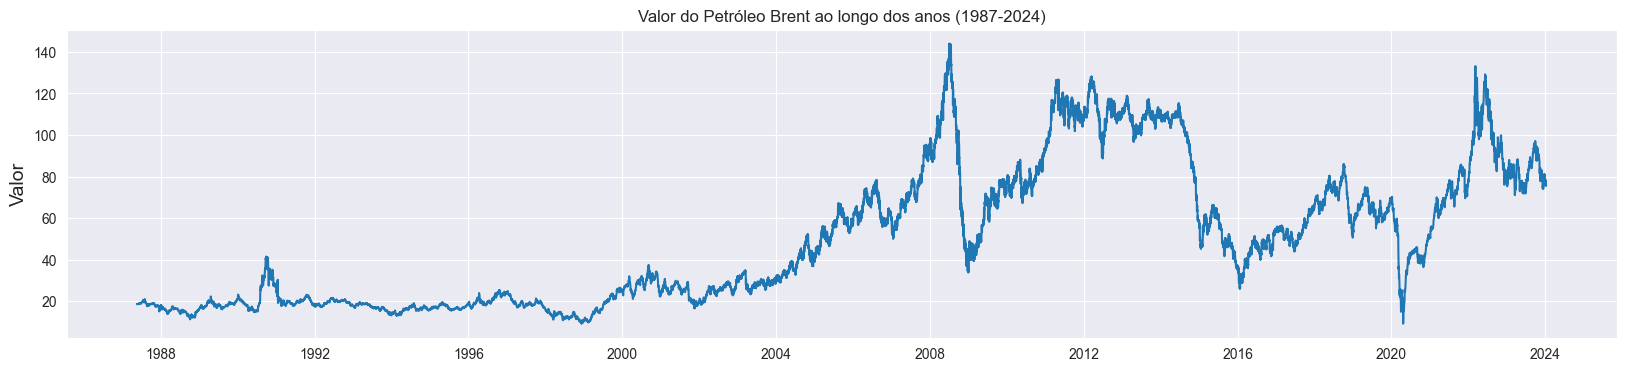

In [122]:
sns.set_style('darkgrid')
plt.figure(figsize=(20, 4))
plt.title('Valor do Petróleo Brent ao longo dos anos (1987-2024)', fontsize=12)
plt.ylabel('Valor', fontsize=14)
plt.xlabel(' ')
sns.lineplot(x=df['ds'], y=df['y'])
plt.show()

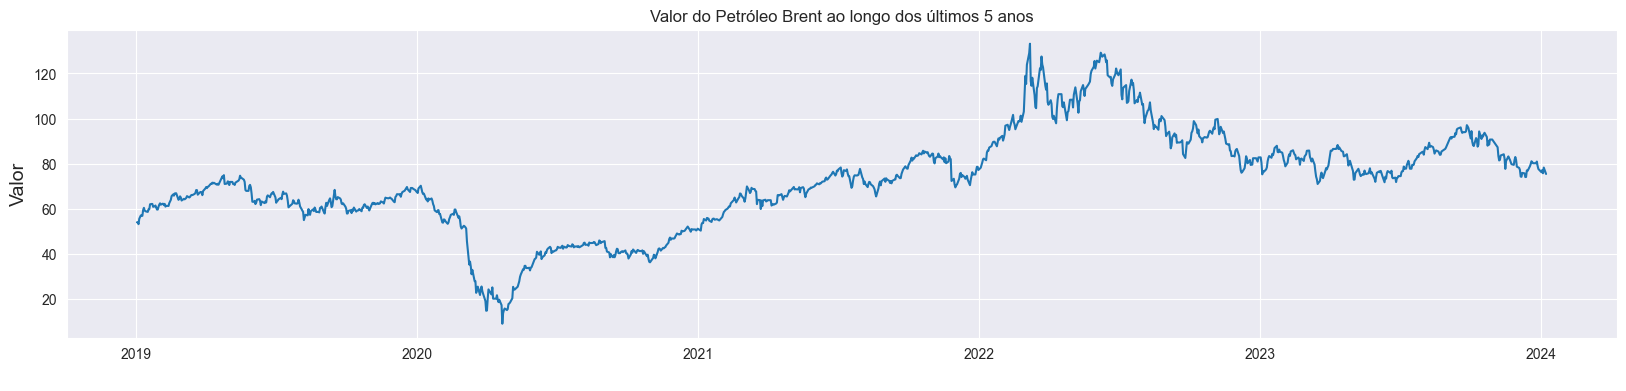

In [133]:
sns.set_style('darkgrid')
plt.figure(figsize=(20, 4))
plt.title('Valor do Petróleo Brent ao longo dos últimos 5 anos', fontsize=12)
plt.ylabel('Valor', fontsize=14)
plt.xlabel(' ')
sns.lineplot(x=df_filtered[df_filtered['ds'] > '2019-01-01']['ds'], y=df_filtered[df_filtered['ds'] > '2019-01-01']['y'])
plt.show()

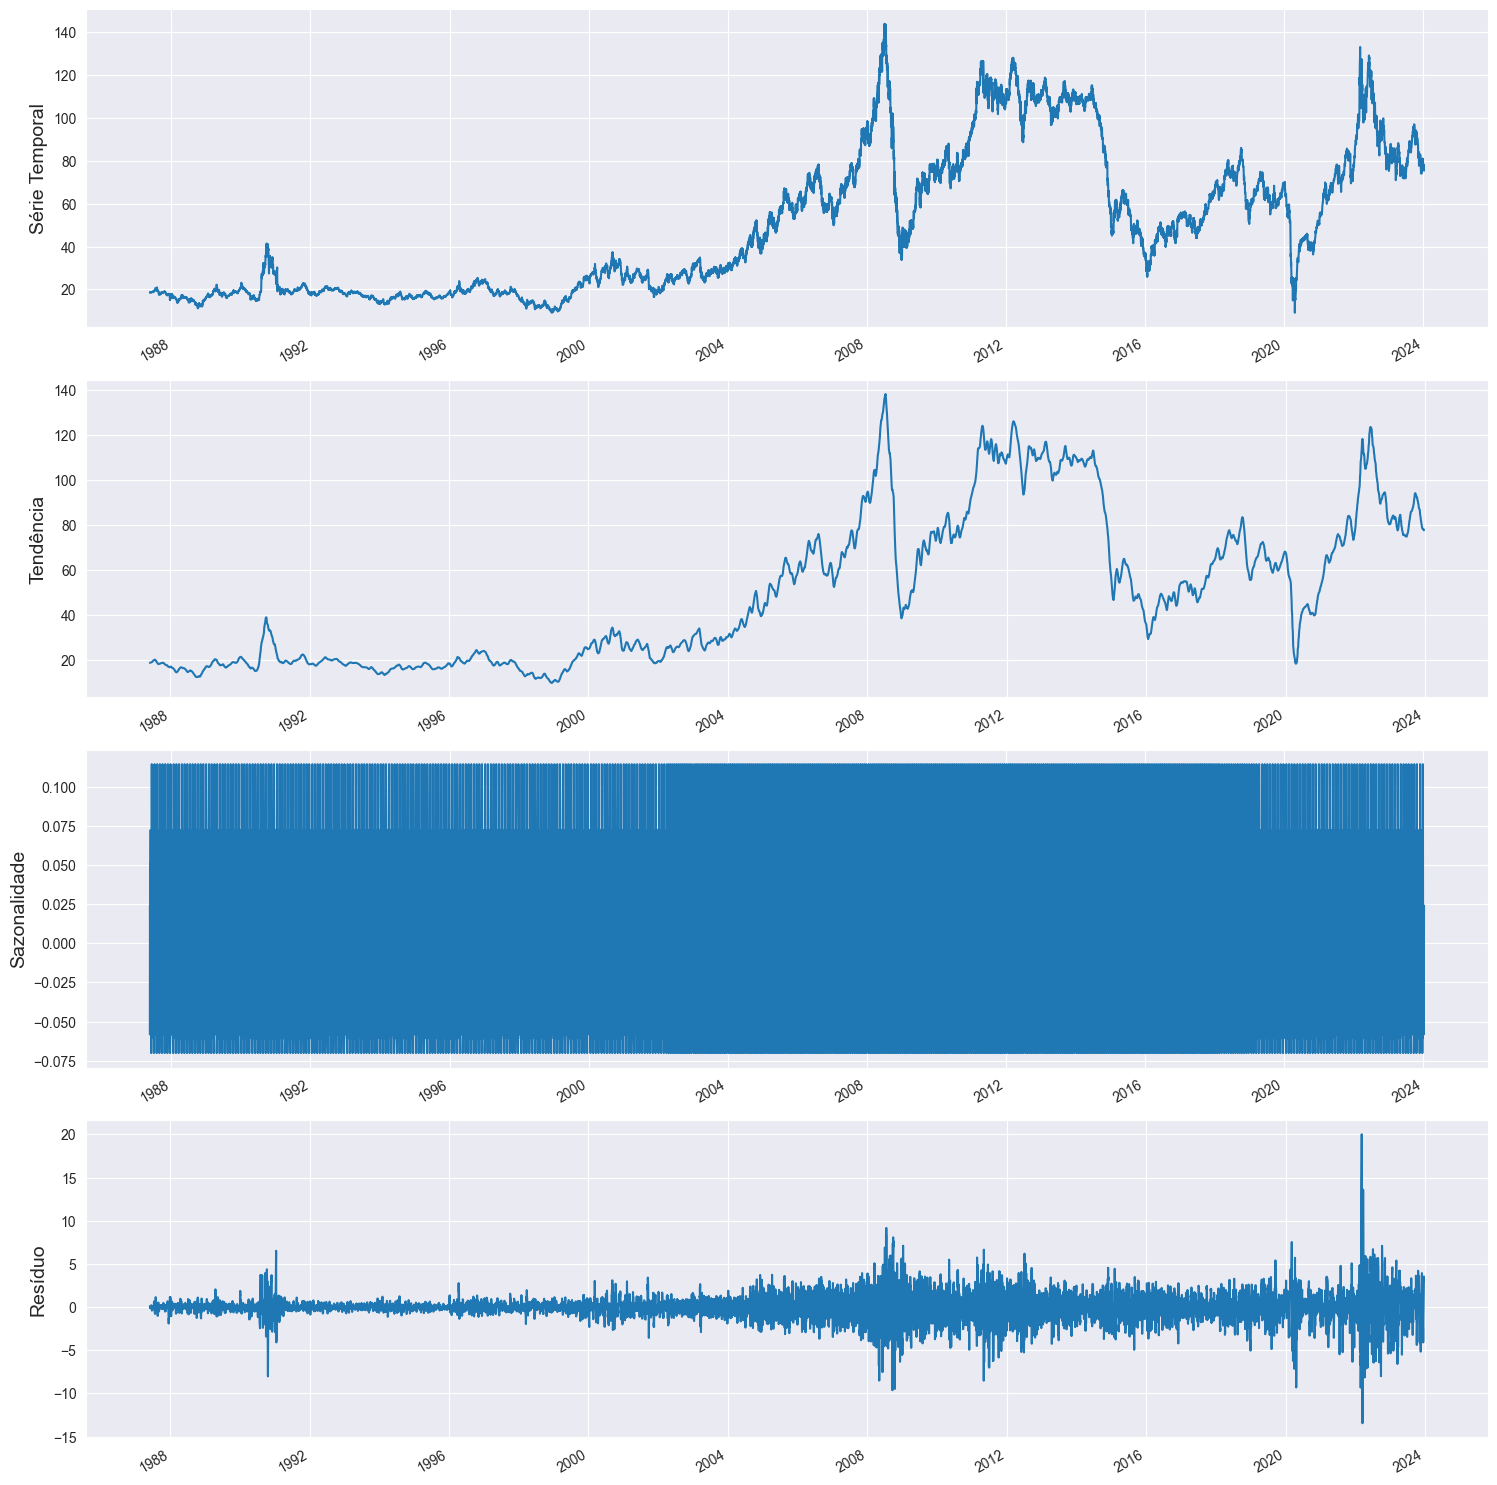

In [124]:
sns.set_style('darkgrid')

df_seasonal_decompose = df_filtered[['ds', 'y']]
df_seasonal_decompose = df_seasonal_decompose = df_seasonal_decompose.set_index('ds')

results = seasonal_decompose(df_seasonal_decompose, period=20) # Média de dias do por mês dataset

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(15, 15))

# Série temporal (mesmo gráfico visto anteriormente)
results.observed.plot(ax=ax1)
ax1.set_ylabel('Série Temporal', fontsize=14)
ax1.set_xlabel('')

# Tendência
results.trend.plot(ax=ax2)
ax2.set_ylabel('Tendência', fontsize=14)
ax2.set_xlabel('')

# Sazonalidade (recorrência)
results.seasonal.plot(ax=ax3)
ax3.set_ylabel('Sazonalidade', fontsize=14)
ax3.set_xlabel('')

# Resíduo 
results.resid.plot(ax=ax4)
ax4.set_ylabel('Resíduo', fontsize=14)
ax4.set_xlabel('')

plt.tight_layout()
plt.show()

# Estacionaridade dos Dados

In [125]:
# Array de valores
X = df_seasonal_decompose['y'].values

# Téste estatístico
result = adfuller(X)

print(
    f'''
    Teste ADF
    Teste estatístico {result[0]}
    P-Value: {result[1]} \n
    Valores críticos:
    '''
)

for key, value in result[4].items():
    print(f'\t{key}: {value}')

# Fica provado que a Série Temporal não é estacionária, P-value é aprox 53,4% e o valor do teste é -2,11


    Teste ADF
    Teste estatístico -2.1122743009388882
    P-Value: 0.23960777273842132 

    Valores críticos:
    
	1%: -3.4309419293887387
	5%: -2.861801600316321
	10%: -2.566909244724719


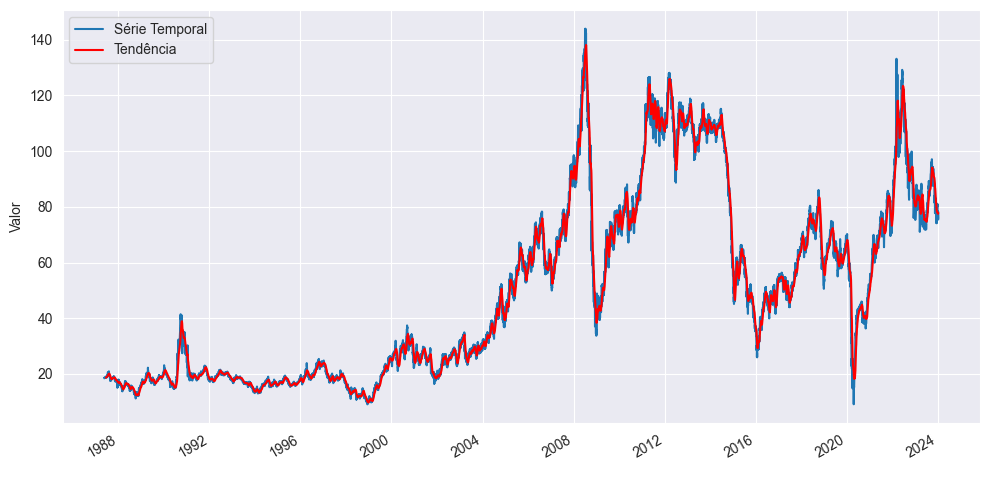

In [126]:
ma = df_seasonal_decompose.rolling(20).mean()

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 5))

df_seasonal_decompose.plot(ax=ax)
ma.plot(ax=ax, color='red')

plt.xlabel(' ')
plt.ylabel('Valor')
plt.tight_layout()
plt.legend(['Série Temporal', 'Tendência'])

plt.show()

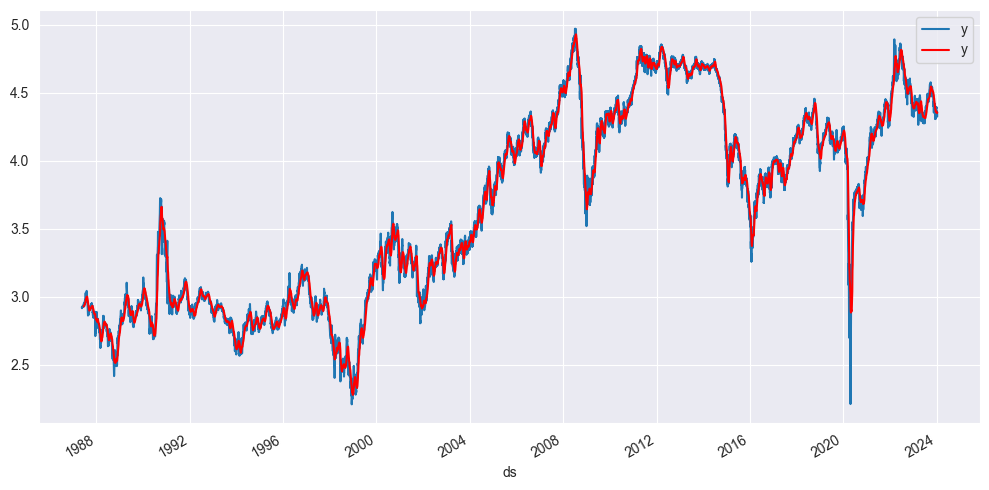

In [127]:
# Aplicar o log
df_log = np.log(df_seasonal_decompose)
ma_log = df_log.rolling(20).mean()

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 5))

df_log.plot(ax=ax)
ma_log.plot(ax=ax, color='red')

plt.tight_layout()
plt.show()

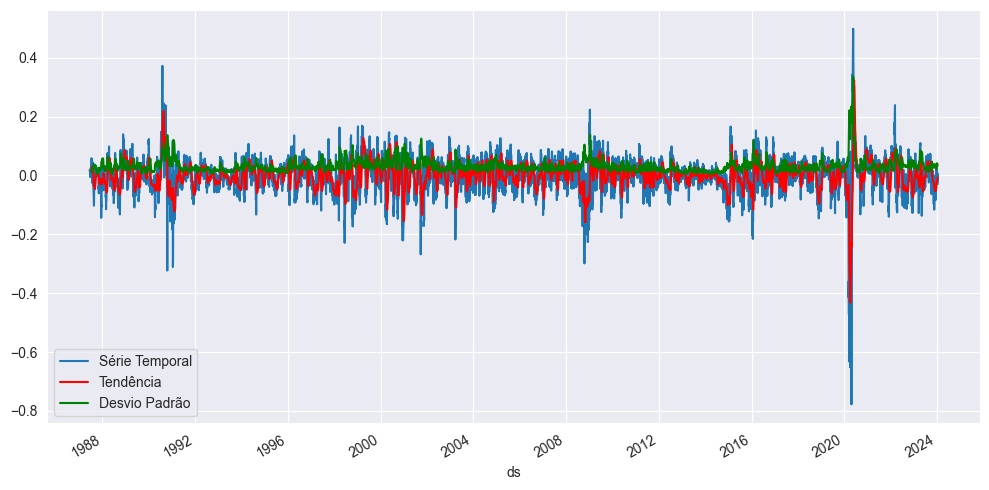

In [128]:
df_s = (df_log - ma_log).dropna()

ma_s = df_s.rolling(20).mean()

std = df_s.rolling(20).std()

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 5))

df_s.plot(ax=ax)
ma_s.plot(ax=ax, color='red')
std.plot(ax=ax, color='green')

plt.legend(['Série Temporal', 'Tendência', 'Desvio Padrão'])
plt.tight_layout()
plt.show()

In [129]:
# Array de valores
X_s = df_s['y'].values

# Téste estatístico
result_s = adfuller(X_s)

print(
    f'''
    Teste ADF
    Teste estatístico {result_s[0]}
    P-Value: {result_s[1]} \n
    Valores críticos:
    '''
)

for key, value in result_s[4].items():
    print(f'\t{key}: {value}')

# Dessa forma a Série Temporal estacionária, P-value é 6,23e-30....


    Teste ADF
    Teste estatístico -17.22639620998785
    P-Value: 6.232740854965275e-30 

    Valores críticos:
    
	1%: -3.4309426267587546
	5%: -2.861801908484863
	10%: -2.5669094087621245


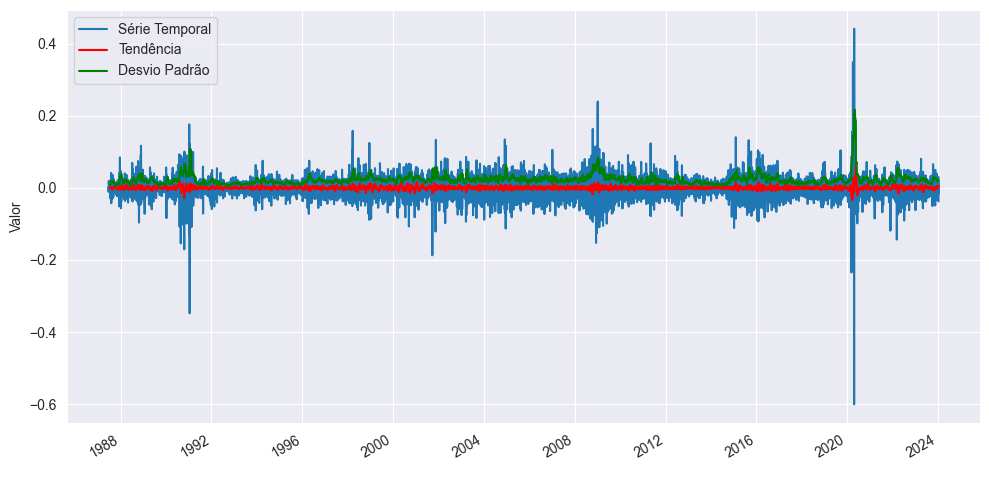

In [130]:
# Aplicando derivada
df_diff = df_s.diff(1) # 1° derivada
ma_diff = df_diff.rolling(20).mean()
std_diff = df_diff.rolling(20).std()

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 5))

df_diff.plot(ax=ax)
ma_diff.plot(ax=ax, color='red')
std_diff.plot(ax=ax, color='green')

plt.legend(['Série Temporal', 'Tendência', 'Desvio Padrão'])
plt.xlabel(' ')
plt.ylabel('Valor')
plt.tight_layout()

plt.show()

In [131]:
# Array de valores
X_diff = df_diff['y'].dropna().values

# Téste estatístico
result_diff = adfuller(X_diff)

print(
    f'''
    Teste ADF
    Teste estatístico {result_diff[0]}
    P-Value: {result_diff[1]} \n
    Valores críticos:
    '''
)

for key, value in result_diff[4].items():
    print(f'\t{key}: {value}')

# Série ficou mais estacionária, P-value é praticamente 0....


    Teste ADF
    Teste estatístico -24.206647462696868
    P-Value: 0.0 

    Valores críticos:
    
	1%: -3.4309433796125974
	5%: -2.8618022411716857
	10%: -2.566909585850568


# Dados de Treino & Metricas de Validação

In [88]:
# A coluna “unique_id” é usada pela classe StatsForecast para identificar séries temporais únicas em dados de painel
# Como o DataFrame contém apenas uma série, colocar todos os valores com 0, indicando que todas as linhas do DataFrame pertencem à mesma série temporal
df['unique_id'] = 0
df.head()
df['ds'].max() - pd.offsets.MonthBegin(3)
train = df.loc[(df['ds'] < df['ds'].max() - pd.offsets.MonthBegin(2))] # Dados de treino
valid = df.loc[(df['ds'] >= df['ds'].max() - pd.offsets.MonthBegin(2))] # Amostra de validação

# horizonte (Quanto eu quero projetar para frente dado um histórico)
# h = valid.index.nunique() # 60 dias
h = 90

In [89]:
# Erro percentual médio absoluto - WMAPE
def __wmape__(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()


def calculate_metrics(y_true, y_pred):
    '''
    Função para calcular métricas de avaliação de modelos de Séries Temporais
    Métricas calculadas:

    Erro Médio Absoluto - MAE
    Erro Quadrático Médio - MSE
    Raiz Quadrada do Erro Médio - RMSE
    Média Percentual Absoluta do Erro - MAPE
    Média Percentual Ponderada Absoluta do Erro - WMAPE
    '''

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred, squared=True)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    wmape = __wmape__(y_true, y_pred)

    print(
        f'''
        MAE: {mae}
        MSE: {mse}
        RMSE: {rmse}
        MAPE: {mape:.2%}
        WMAPE: {wmape:.2%}
        '''
    )

# GradientBoostRegressor

In [18]:
df_gradient = df[['ds', 'value']].copy()

# Criação de lag features
for n_lag in range(1, 4):
    df_gradient[f'lag_{n_lag}'] = df_gradient['value'].shift(n_lag)

# Remover os vázios por conta dos 3 primeiros dias do dataset (que não tem valores dos últimos 3 dias)
df_gradient = df_gradient.dropna()

# Separar os valores para o treinamento
x = df_gradient[['lag_1', 'lag_2', 'lag_3']].values
y = df_gradient[['value']].values

# Dividir o dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=False)

# Treinar modelo
model_gradient = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=0, loss='squared_error')
model_gradient.fit(x_train, y_train)

# Fazer predições
y_pred = model_gradient.predict(x_test)

# Avaliar modelo
y_test_value = pd.DataFrame(y_test, columns=['Value'])
calculate_metrics(y_test_value['Value'].values, y_pred)

C:\Users\mathem23\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



        MAE: 1.3640137703900361
        MSE: 3.5760878396317852
        RMSE: 1.89105468975167
        MAPE: 2.16%
        WMAPE: 1.93%
        


# StatsForecast Naive

In [31]:
model_arima = StatsForecast(
    models=[Naive()],
    freq='d', # Frequência em dias
    n_jobs=-1 # Todas as cpus disponíeis do computador, para rodar de maneira mais rápida (paralelização)
    )

# Treinando modelo
model_arima.fit(train)

# Predizendo valores
df_forecast = model_arima.predict(h=h, level=[90]) # level: nível de precisão em porcentagem
df_forecast = df_forecast.reset_index().merge(valid, on=['ds', 'unique_id'], how='right')
# df_forecast = df_forecast.dropna(subset='y')

# Validação
calculate_metrics(df_forecast['y'].values, df_forecast['Naive'].values)


        MAE: 4.1916012207031255
        MSE: 22.417462233399934
        RMSE: 4.734708252194631
        MAPE: 5.49%
        WMAPE: 5.41%
        


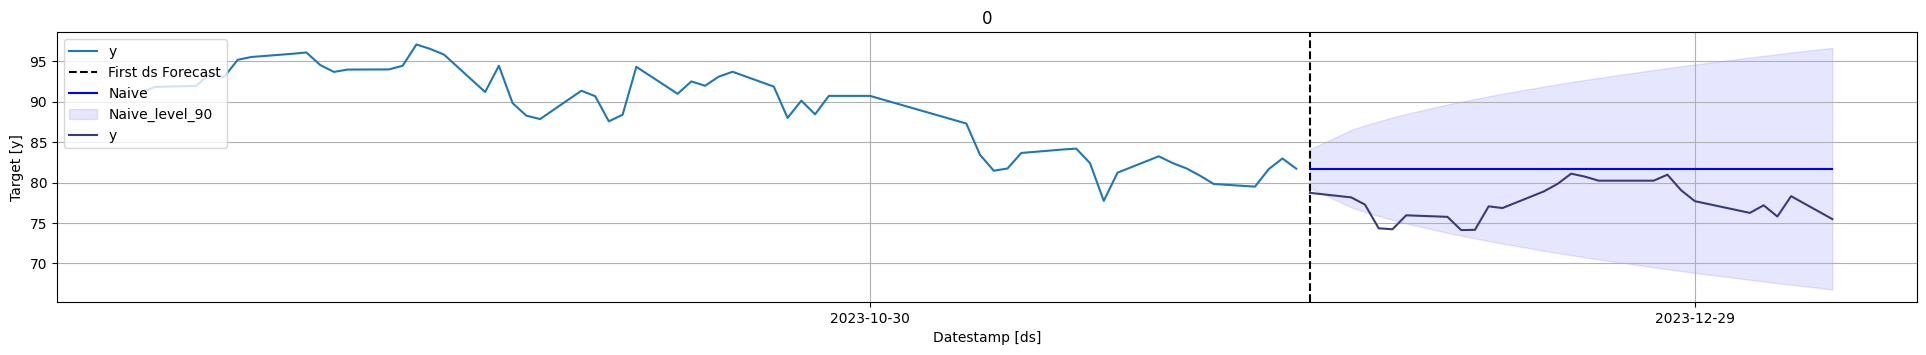

In [32]:
model_arima.plot(
    train[11000:], 
    df_forecast, 
    level=[90], 
    unique_ids=[0],
    engine='matplotlib'
    )

# Statsforecast SeasonalNaive

In [97]:
# Baseline model, se baseando na última data e com SAZONALIDADE

model_s = StatsForecast(
    models=[SeasonalNaive(season_length=5)], # season_length: dias
    freq='d', # Frequência em dias
    n_jobs=-1 # Todas as cpus disponíeis do computador, para rodar de maneira mais rápida (paralelização)
    )

# Treinando modelo
model_s.fit(train)

# Predizendo valores
df_forecast_s = model_s.predict(h=h, level=[90]) # level: nível de precisão em porcentagem
df_forecast_s = df_forecast_s.reset_index().merge(valid, on=['ds', 'unique_id'], how='right')
# df_forecast_s = df_forecast_s.dropna(subset='y')

# Validação
calculate_metrics(df_forecast_s['y'].values, df_forecast_s['SeasonalNaive'].values)


        MAE: 3.952401708984376
        MSE: 20.38033162012357
        RMSE: 4.51445806494241
        MAPE: 5.17%
        WMAPE: 5.10%
        


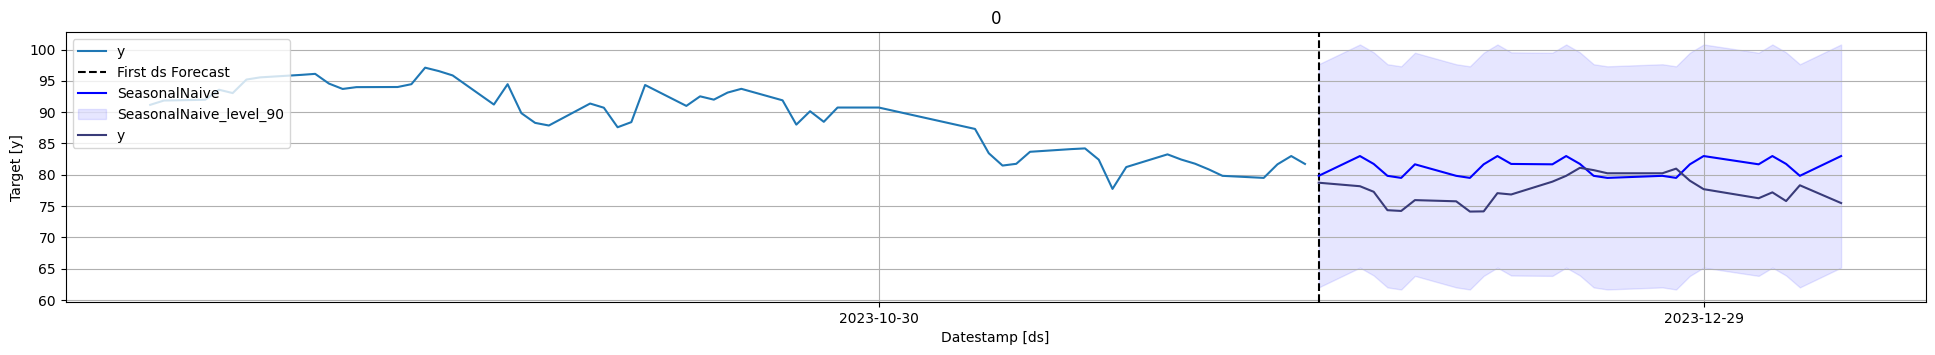

In [98]:
model_s.plot(
    train[11000:], 
    df_forecast_s, 
    level=[90], 
    unique_ids=[0],
    engine='matplotlib'
    )

# StatsForecast SeasonalWindowAverage

In [103]:
model_swa = StatsForecast(
    models=[SeasonalWindowAverage(season_length=5, window_size=1)], # season_length: dias, window_size=2 :média móvel das últimas 2 meses
    freq='d', # Frequência em dias
    n_jobs=-1 # Todas as cpus disponíeis do computador, para rodar de maneira mais rápida (paralelização)
    )

# Treinando modelo
model_swa.fit(train)

# Predizendo valores
df_forecast_swa = model_swa.predict(h=h, level=[90]) # level: nível de precisão em porcentagem
df_forecast_swa = df_forecast_swa.reset_index().merge(valid, on=['ds', 'unique_id'], how='right')
# df_forecast_swa = df_forecast_swa.dropna(subset='y')

# Validação
calculate_metrics(df_forecast_swa['y'].values, df_forecast_swa['SeasWA'].values)


        MAE: 3.952401708984376
        MSE: 20.38033162012357
        RMSE: 4.51445806494241
        MAPE: 5.17%
        WMAPE: 5.10%
        


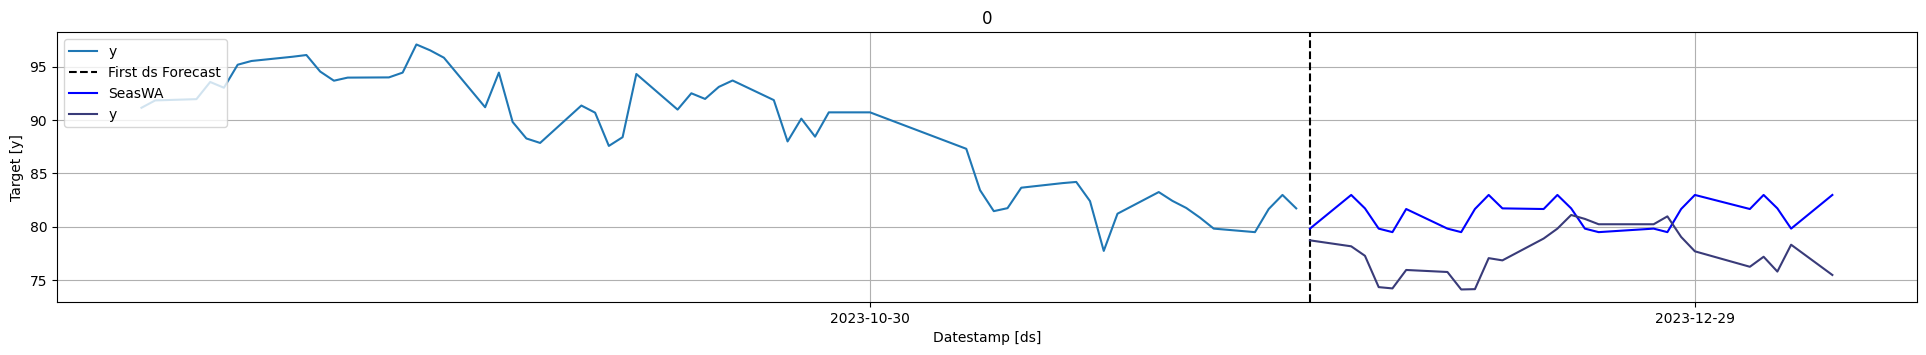

In [104]:
model_swa.plot(
    train[11000:], 
    df_forecast_swa, 
    level=[90], 
    unique_ids=[0],
    engine='matplotlib'
    )

# AutoARIMA

In [66]:
model_arima = StatsForecast(
    models=[AutoARIMA(season_length=10)],
    freq='d', # Frequência em dias
    n_jobs=-1 # Todas as cpus disponíeis do computador, para rodar de maneira mais rápida (paralelização)
    )

# Treinando modelo
model_arima.fit(train)

# Predizendo valores
df_forecast_arima = model_arima.predict(h=h+5, level=[90]) # level: nível de precisão em porcentagem
df_forecast_arima = df_forecast_arima.reset_index().merge(valid, on=['ds', 'unique_id'], how='right')
# df_forecast_arima = df_forecast_arima.dropna(subset='y')

# Validação
calculate_metrics(df_forecast_arima['y'].values, df_forecast_arima['AutoARIMA'].values)


        MAE: 4.318871423339844
        MSE: 23.574359938923138
        RMSE: 4.8553434419125425
        MAPE: 5.66%
        WMAPE: 5.57%
        


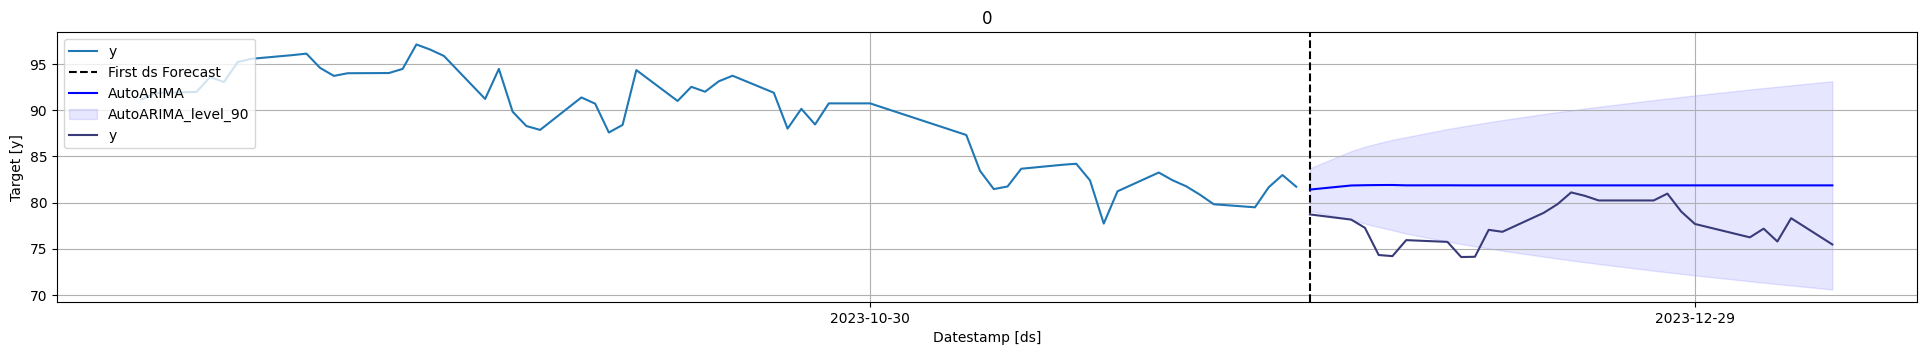

In [68]:
model_arima.plot(
    train[11000:], 
    df_forecast_arima, 
    level=[90], 
    unique_ids=[0],
    engine='matplotlib'
    )

# Prophet

In [69]:
# Apenas 'ds' e 'y'
train = train.reset_index()

In [71]:
# Modelo
m = Prophet(daily_seasonality=True)
m.fit(train)

# Predizendo valores
future = m.make_future_dataframe(periods=100)
df_forecast_prophet = m.predict(future)
df_forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

22:14:14 - cmdstanpy - INFO - Chain [1] start processing
22:14:43 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
11152,2024-03-05,91.023955,79.265771,103.805832
11153,2024-03-06,90.985963,78.050606,103.811999
11154,2024-03-07,91.064188,78.774062,103.871871
11155,2024-03-08,91.072188,78.771118,103.265869
11156,2024-03-09,91.552131,79.096589,103.598314


In [72]:
df_forecast_validation = valid.merge(df_forecast_prophet, how='left', on='ds')

# Validação
calculate_metrics(df_forecast_validation['y'].values, df_forecast_validation['yhat'].values)


        MAE: 9.393719946224012
        MSE: 93.39342408726795
        RMSE: 9.664027322357276
        MAPE: 12.21%
        WMAPE: 12.12%
        


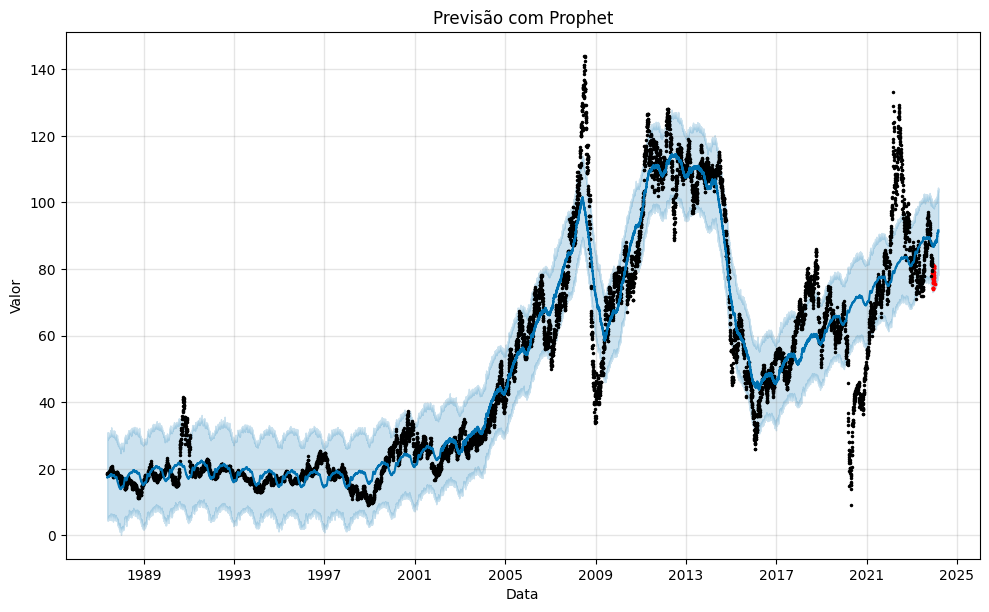

In [79]:
fig1 = m.plot(df_forecast_prophet)

ax = fig1.gca()

# Personalização do gráfico
ax.set_title('Previsão com Prophet')
ax.set_xlabel('Data')
ax.set_ylabel('Valor')
plt.setp(ax.get_lines()[0], markersize=3) # Altera o tamanho dos pontos de dados reais para 

# Adicionando outro gráfico de dispersão
x = valid['ds'] # valores x do novo gráfico de dispersão
y = valid['y']  # valores y do novo gráfico de dispersão
ax.scatter(x, y, color='red', s=3) # Adiciona o novo gráfico de dispersão com pontos verdes